# Quickstart

This notebook is intended to demonstrate the basic usage of `superscreen` by calculating the magnetic response of several simple single-layer devices.

In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

import os

os.environ["OPENBLAS_NUM_THREADS"] = "1"

import logging

logging.basicConfig(level=logging.INFO)

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 14

import superscreen as sc
from superscreen.geometry import circle, box

## Device geometry and materials

- **Layers** represent different physical planes in a device. All superconducting films in a given layer
  are assumed to have the same thickness and penetration depth.
- **Films** represent the actual superconducting films, which may fill only part of the `Layer` that they are in,
  and may have one or more holes. Each film can have an arbitrary polygonal geometry, and there can be multiple         (non-overlapping) films per layer.
- **Holes** are polygonal regions of vacuum completely surrounded (in 2D) by a superconducting film, which can contain   trapped flux.
- **Abstract regions** are polygonal regions which need not represent any real geometry in the device.   Abstract regions will be meshed just like films and holes, and after solving a `Device`, one can calculate the flux through all abstract regions. Abstract regions can be used to define a "bounding box," a region of vacuum outside of the convex hull of all the films that will be meshed and simulated.

## Superconducting ring with a slit

Here we define a superconducting ring with inner radius 1 $\mu$m, outer radius 3 $\mu$m, London penetration depth $\lambda=100$ nm, and thickness $d=25$ nm, for an effective penetration depth of $\Lambda=\lambda^2/d=400$ nm. The ring also has a slit of width 250 nm in it.

In [2]:
length_units = "um"
ro = 3  # outer radius
ri = 1  # inner radius
slit_width = 0.25
layer = sc.Layer("base", london_lambda=0.100, thickness=0.025, z0=0)

ring = circle(ro)
hole = circle(ri)
slit = box(slit_width, 1.5 * (ro - ri), center=(0, -(ro + ri) / 2))

film = sc.Polygon.from_difference(
    [ring, slit, hole], name="ring_with_slit", layer="base"
)
# # The above is equivalent to all of the following:
# film = sc.Polygon(
#     name="ring_with_slit", layer="base", points=ring
# ).difference(slit, hole)
# film = sc.Polygon(
#     name="ring_with_slit", layer="base", points=ring
# ).difference(slit).difference(hole)
# film = sc.Polygon(
#     name="ring_with_slit", layer="base", points=ring
# ).difference(sc.Polygon(points=hole).union(slit))

film = film.resample(500)
bounding_box = sc.Polygon("bounding_box", layer="base", points=circle(1.2 * ro))

device = sc.Device(
    film.name,
    layers=[layer],
    films=[film],
    abstract_regions=[bounding_box],
    length_units=length_units,
)

In [3]:
print(device)

Device(
    "ring_with_slit", 
    layers=[
        Layer("base", Lambda=0.400, thickness=0.025, london_lambda=0.100, z0=0.000),
    ], 
    films=[
        Polygon(name="ring_with_slit", layer="base", points=<ndarray: shape=(500, 2)>, mesh=True),
    ], 
    holes=None, 
    abstract_regions=[
        Polygon(name="bounding_box", layer="base", points=<ndarray: shape=(101, 2)>, mesh=True),
    ], 
    length_units="um",
)


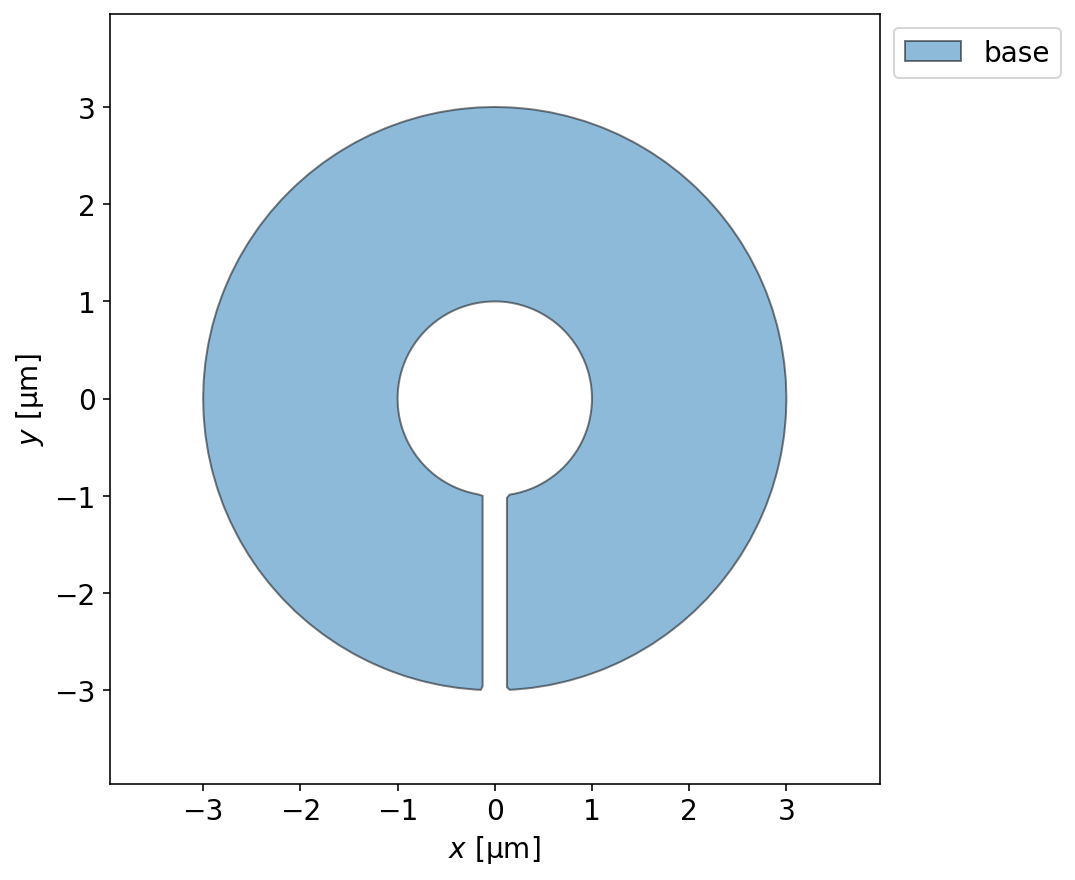

In [4]:
fig, ax = device.draw(exclude="bounding_box", legend=True)

### Generate the mesh

In [5]:
device.make_mesh(min_points=4_000, optimesh_steps=10)

INFO:superscreen.device.device:Generating mesh...
INFO:superscreen.device.device:Optimizing mesh with 4355 vertices.
/Users/LoganBVH/opt/anaconda3/envs/superscreen/lib/python3.9/site-packages/meshplex/_mesh_tri.py:345: UserWarning: There are 2 remaining non-Delaunay facets. The signed circumcenter distances are [-9.71445146547012e-17, -1.0408340855860843e-17]. This can happen due to round-off errors or to prevent non-manifold edges in shell meshes.
  warnings.warn(
INFO:superscreen.device.device:Finished generating mesh with 4355 points and 8543 triangles.
INFO:superscreen.device.device:Calculating weight matrix.
INFO:superscreen.device.device:Calculating Laplace operator.
INFO:superscreen.device.device:Calculating kernel matrix.
INFO:superscreen.device.device:Calculating gradient matrix.


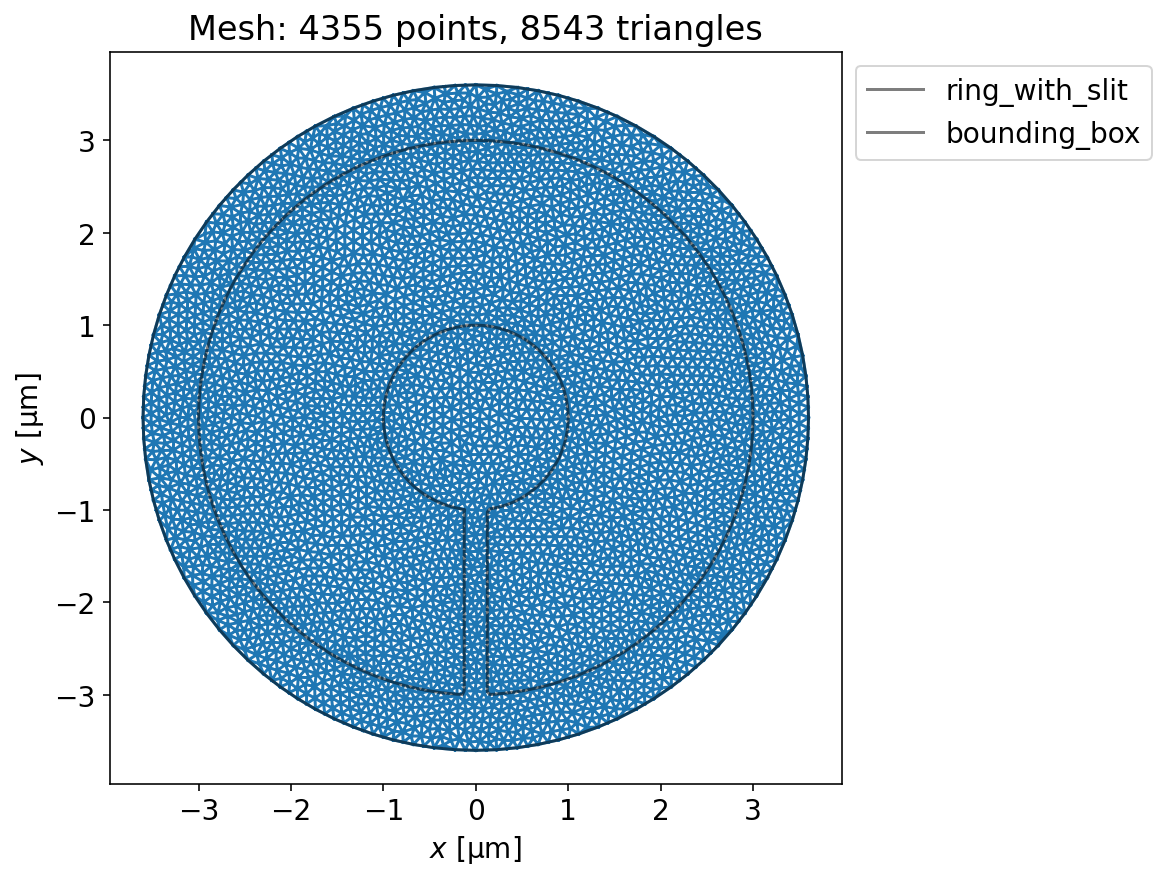

In [6]:
fig, ax = device.plot(color="k", alpha=0.5, mesh=True)
_ = ax.set_title(
    f"Mesh: {device.points.shape[0]} points, " f"{device.triangles.shape[0]} triangles"
)

### Simulate Meissner screening

Here we apply a uniform field field in the $+z$ direction and calculate the ring's magnetic response.

In [7]:
applied_field = sc.sources.ConstantField(1)

solutions = sc.solve(
    device=device,
    applied_field=applied_field,
    field_units="uT",
    current_units="uA",
)
assert len(solutions) == 1
solution = solutions[-1]

INFO:superscreen.solve:Calculating base response to applied field.


In [8]:
xs = np.linspace(-3.5, 3.5, 401)

cross_section_coords = [
    # [x-coords, y-coords]
    np.stack([xs, 0 * xs], axis=1),  # horizontal cross-section
    np.stack([xs, -2 * np.ones_like(xs)], axis=1),  # horizontal cross-section
    np.stack([0 * xs, xs], axis=1),  # vertical cross-section
]

#### Visualize the fields

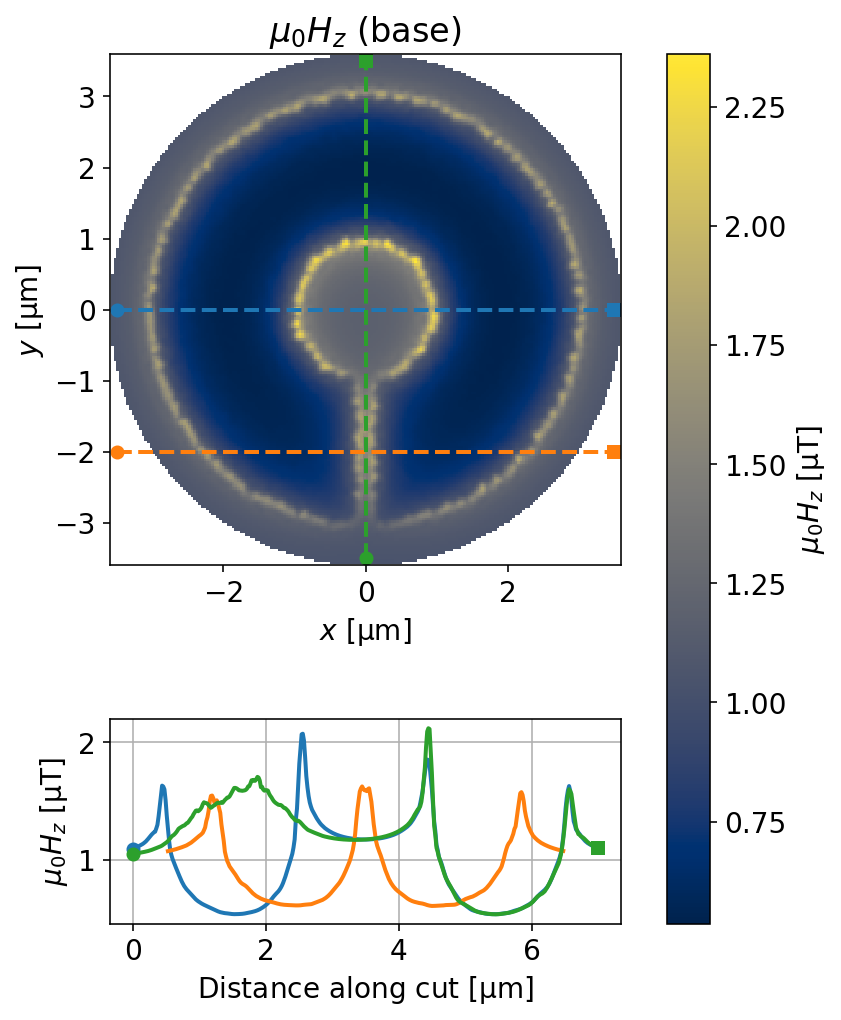

In [9]:
fig, axes = solution.plot_fields(
    cross_section_coords=cross_section_coords, figsize=(6, 8)
)

#### Visualize the currents

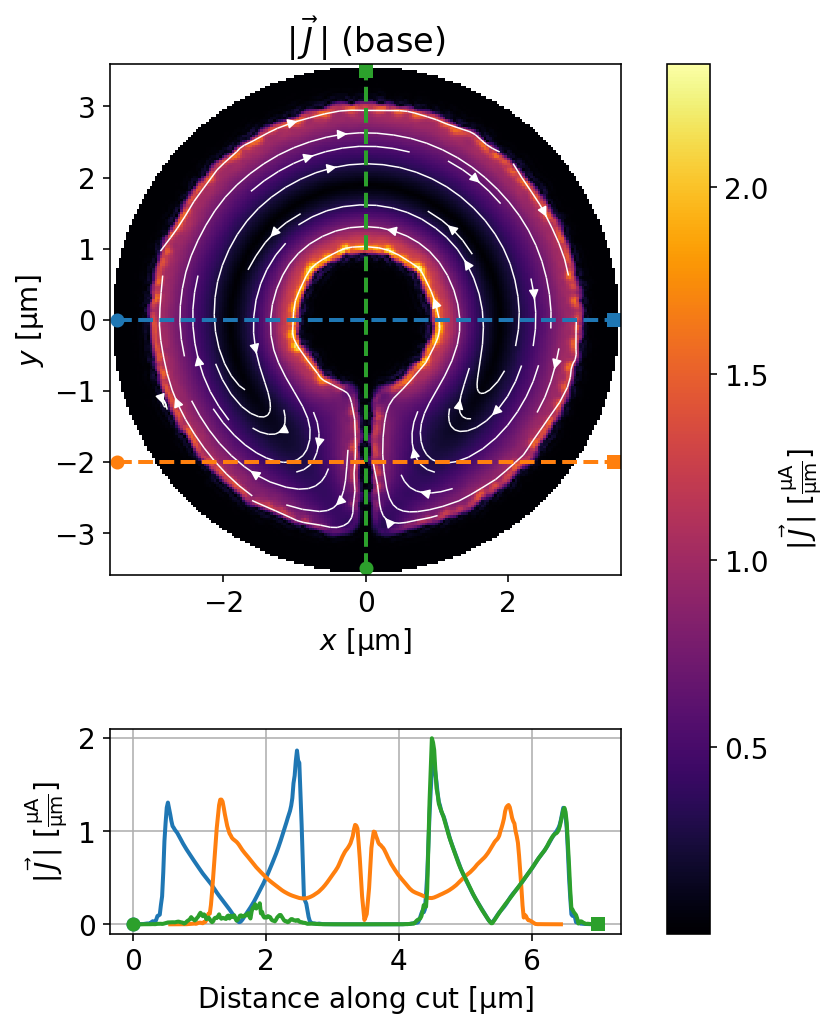

In [10]:
fig, axes = solution.plot_currents(
    cross_section_coords=cross_section_coords,
    figsize=(6, 8),
)

### Simulate trapped vortices

We represent a trapped vortex as an instance of the `superscreen.Vortex` class. Here we assume no applied field.

In [11]:
vortices = [
    sc.Vortex(x=1.5, y=1.5, layer="base"),
    sc.Vortex(x=-1.5, y=-1.5, layer="base"),
    sc.Vortex(x=0, y=2.5, layer="base"),
]

solutions = sc.solve(
    device=device, vortices=vortices, field_units="mT", current_units="mA"
)
assert len(solutions) == 1
solution = solutions[-1]

INFO:superscreen.solve:Calculating base response to applied field.


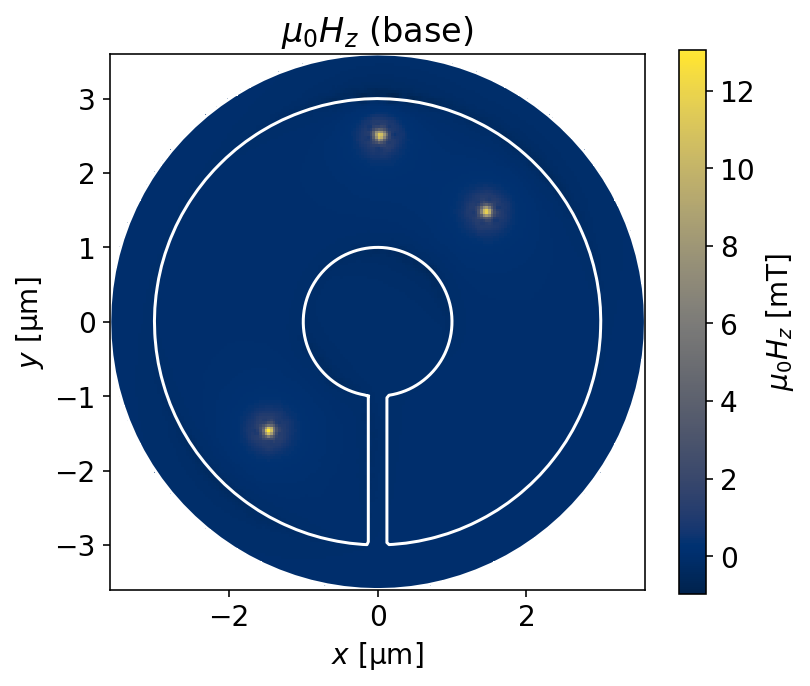

In [12]:
fig, axes = solution.plot_fields(figsize=(6, 5))
for ax in axes:
    device.plot(ax=ax, color="w", legend=False)

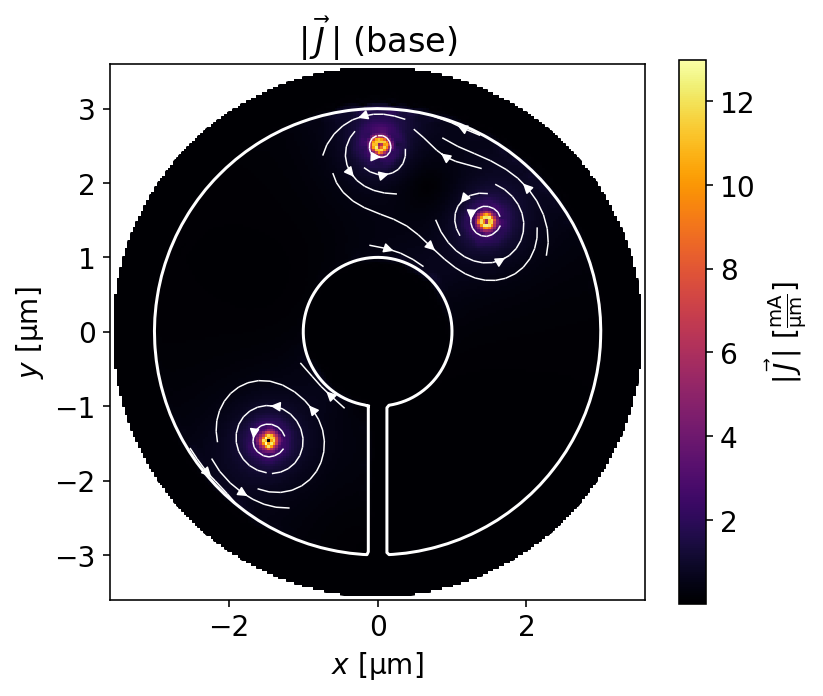

In [13]:
fig, axes = solution.plot_currents(figsize=(6, 5))
for ax in axes:
    device.plot(ax=ax, color="w", legend=False)

## Inhomogeneous penetration depth

Here we set the London penetration depth $\lambda$ of the ring to be spatially non-uniform. In particular, we set $\lambda(x, y)$ to be linearly increasing as a function of the angle between the point $\vec{r}=(x, y)$ and the $-y$ axis.

### Define a `Parameter` to compute $\lambda(x, y)$

In [14]:
def linear_vs_angle(
    x: np.ndarray, y: np.ndarray, *, min_val: float, max_val: float
) -> np.ndarray:
    # Rotate the input coordinates so that theta = 0
    # corresponds to the slit position (along the -y axis).
    x, y = sc.geometry.rotate(
        np.stack(np.atleast_1d(x, y), axis=1), np.degrees(-np.pi / 2)
    ).T
    # Calculate the angular position of each mesh vertex.
    angles = np.arctan2(y, x) + np.pi  # range: [0, 2 * pi]
    # Set london_lambda to increase linearly from min_val to max_val
    # as a function of angular position.
    lambdas = angles / (2 * np.pi) * (max_val - min_val) + min_val
    return lambdas


london_lambda = sc.Parameter(linear_vs_angle, min_val=0.1, max_val=0.5)
print(london_lambda)

Parameter<linear_vs_angle(min_val=0.1, max_val=0.5)>


### Solve the model and visualize the results

In [15]:
# Assign the Parameter london_lambda as the London penetration depth of the superconducting layer.
device.layers["base"].london_lambda = london_lambda
# Generate the mesh and solve.
solution = sc.solve(
    device,
    applied_field=sc.sources.ConstantField(10),
    field_units="uT",
)[-1]

INFO:superscreen.solve:Calculating base response to applied field.


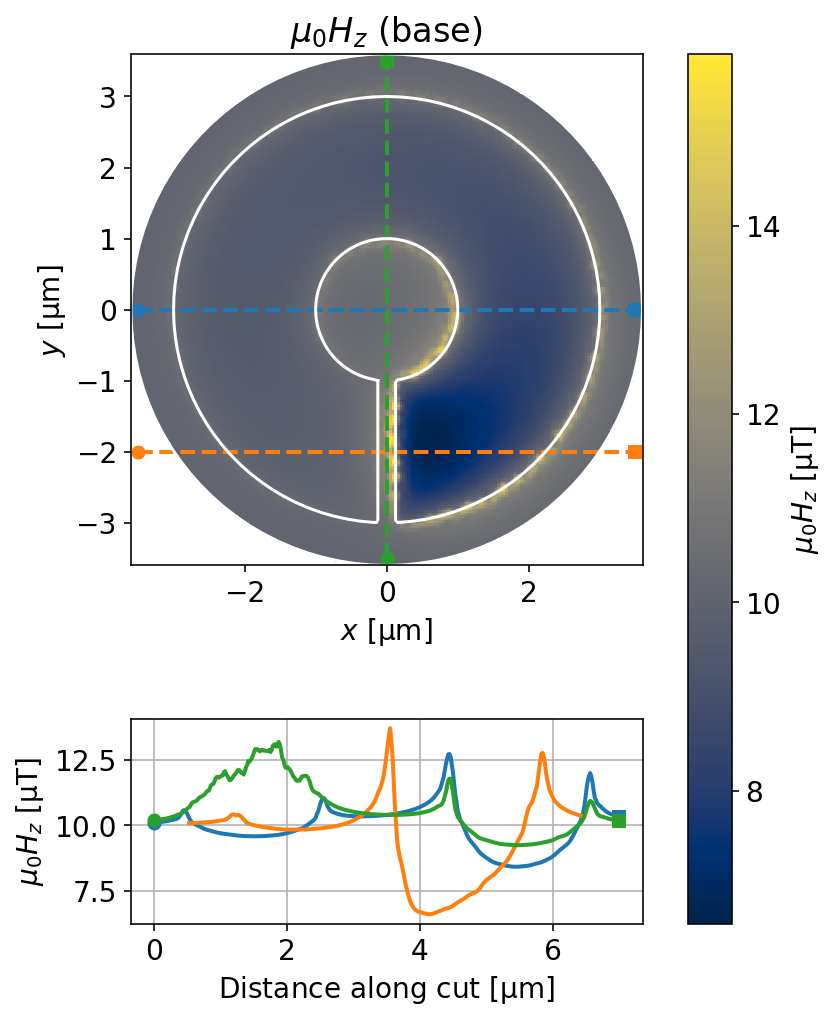

In [16]:
fig, axes = solution.plot_fields(
    cross_section_coords=cross_section_coords, figsize=(6, 8)
)
for ax in axes:
    device.plot(ax=ax, color="w", legend=False)

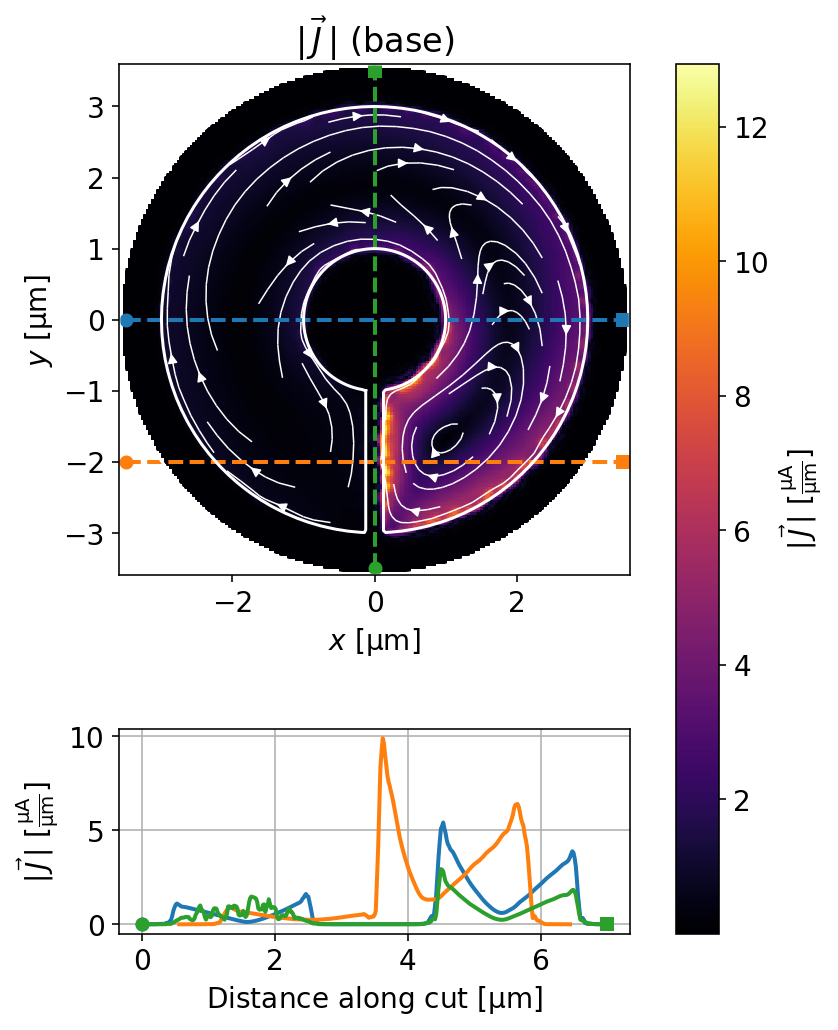

In [17]:
fig, axes = solution.plot_currents(
    cross_section_coords=cross_section_coords, figsize=(6, 8)
)
for ax in axes:
    device.plot(ax=ax, color="w", legend=False)

## Superconducting ring without a slit

Let's see what happens if we add a hole to our device (making it a ring or washer).

In [18]:
device = sc.Device(
    "ring",
    layers=[sc.Layer("base", london_lambda=0.100, thickness=0.025, z0=0)],
    films=[sc.Polygon("ring", layer="base", points=ring)],
    holes=[sc.Polygon("hole", layer="base", points=hole)],
    abstract_regions=[bounding_box],
    length_units=length_units,
)

In [19]:
device.make_mesh(min_points=4_000, optimesh_steps=10)

INFO:superscreen.device.device:Generating mesh...
INFO:superscreen.device.device:Optimizing mesh with 4178 vertices.
/Users/LoganBVH/opt/anaconda3/envs/superscreen/lib/python3.9/site-packages/meshplex/_mesh_tri.py:345: UserWarning: There are 1 remaining non-Delaunay facets. The signed circumcenter distances are [-3.469446951953614e-17]. This can happen due to round-off errors or to prevent non-manifold edges in shell meshes.
  warnings.warn(
INFO:superscreen.device.device:Finished generating mesh with 4178 points and 8184 triangles.
INFO:superscreen.device.device:Calculating weight matrix.
INFO:superscreen.device.device:Calculating Laplace operator.
INFO:superscreen.device.device:Calculating kernel matrix.
INFO:superscreen.device.device:Calculating gradient matrix.


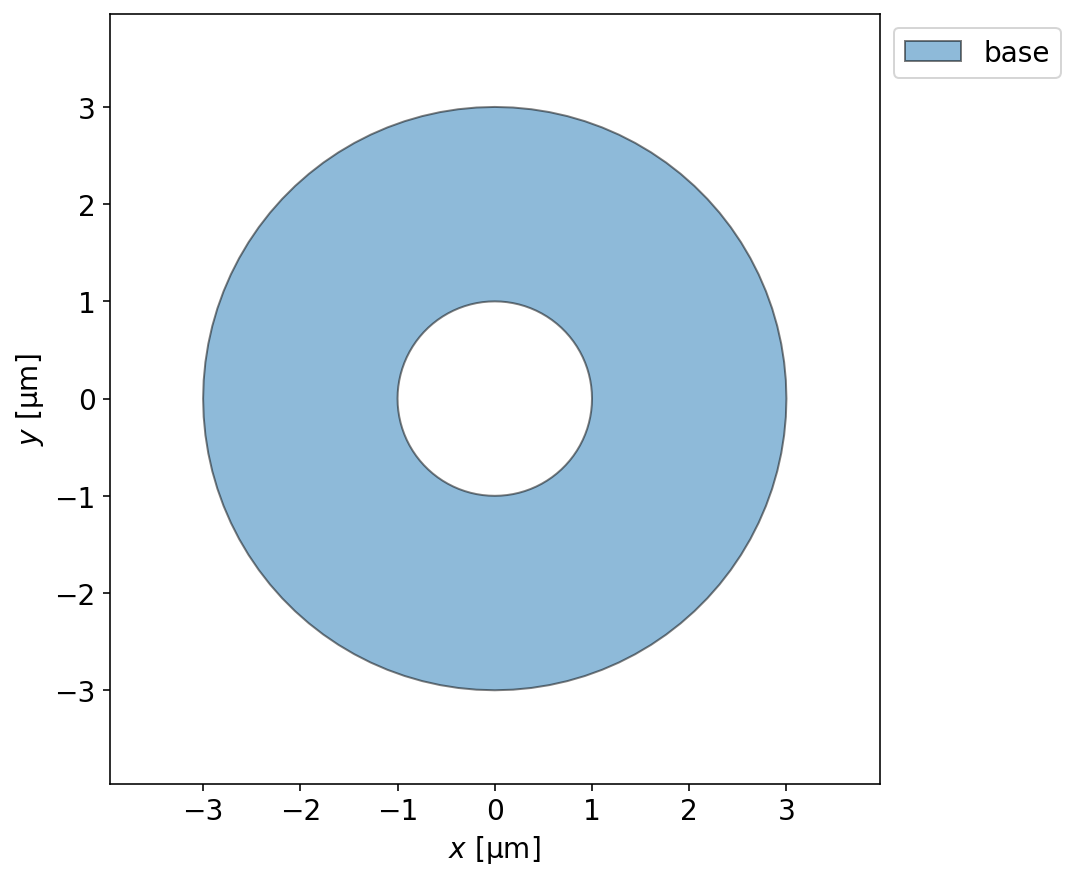

In [20]:
fig, ax = device.draw(exclude="bounding_box", legend=True)

### Trapped flux

We can also solve for the field and current distribution from circulating currents associated with flux trapped in the hole.

We assume there is a total current of 1 mA circulating clockwise in the ring (associated with some positive net trapped flux), and that there is otherwise no applied magnetic field. From here we can calculate the current distribution in the ring, the total magnetic field in the plane of the ring, and the flux through the ring.

Note that, although here we are assuming no applied field, we can also solve models with both trapped flux and applied fields.

In [21]:
circulating_currents = {"hole": "1 mA"}

solutions = sc.solve(
    device,
    circulating_currents=circulating_currents,
    field_units="mT",
    current_units="mA",
)
solution = solutions[-1]

INFO:superscreen.solve:Calculating base response to applied field.


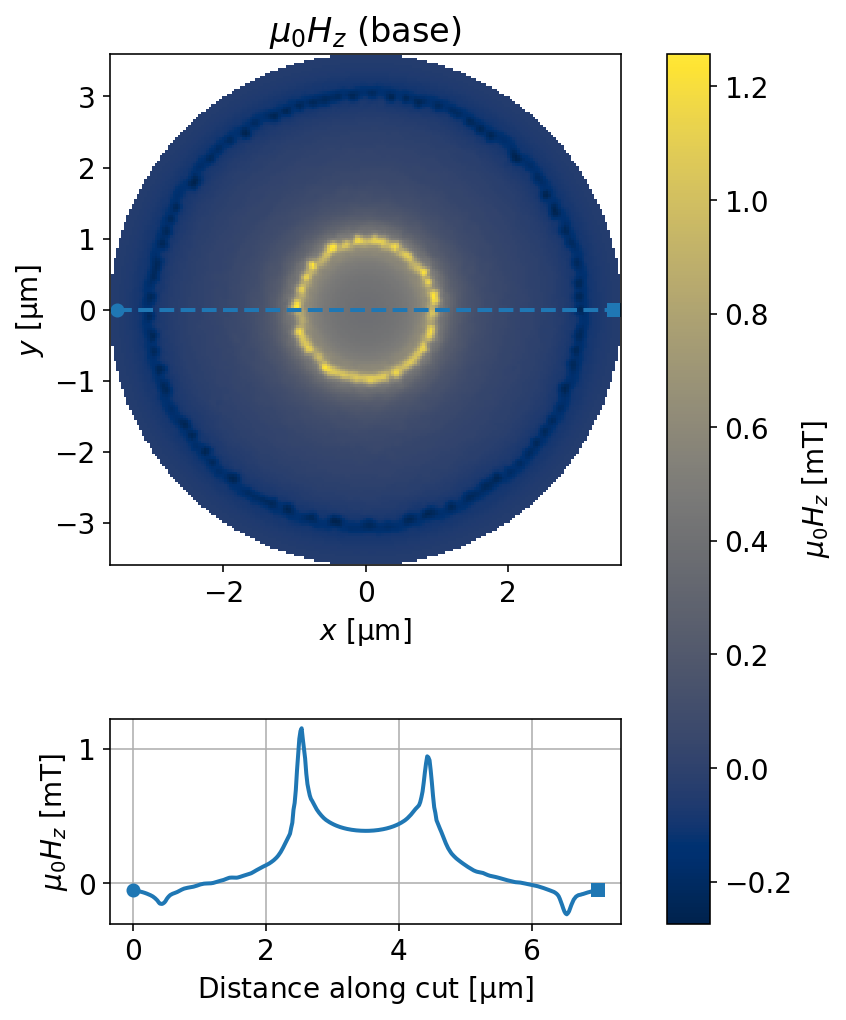

In [22]:
fig, axes = solution.plot_fields(
    cross_section_coords=cross_section_coords[:1], figsize=(6, 8)
)

### Verify the circulating current by integrating the current density $\vec{J}$

x cut, total current: 1.00188 mA (error = 0.188%)
y cut, total current: 0.99982 mA (error = 0.018%)


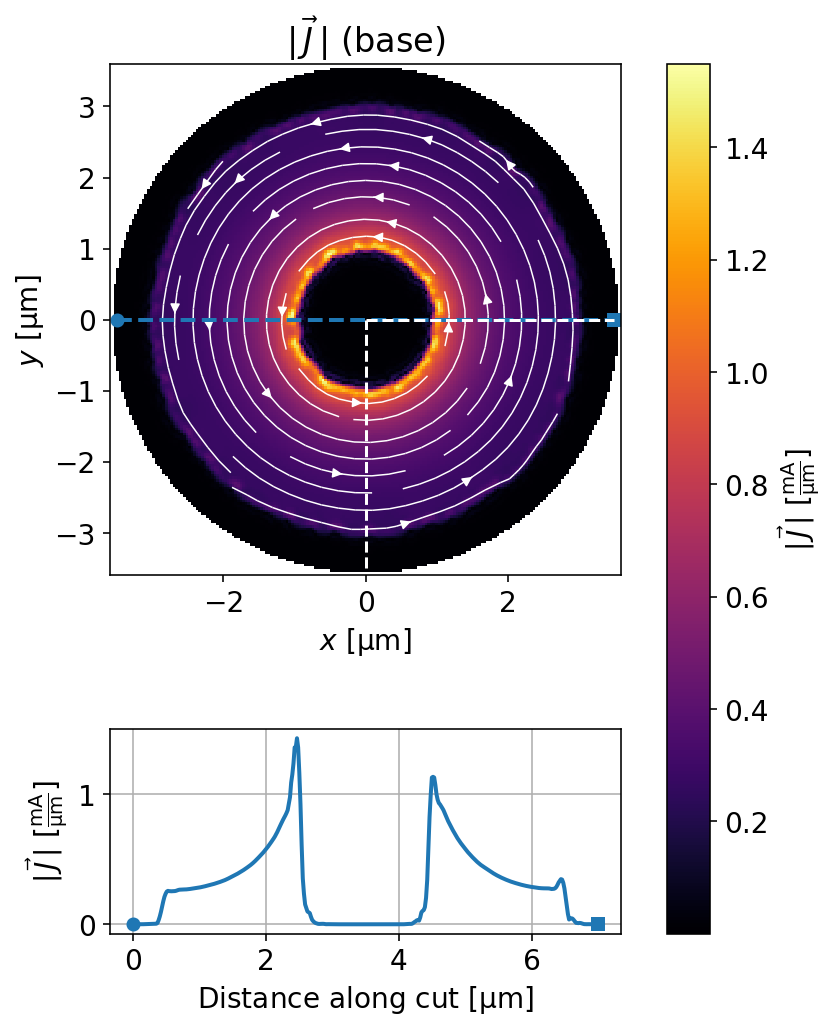

In [23]:
fig, axes = solution.plot_currents(
    units="mA/um",
    cross_section_coords=cross_section_coords[:1],
    figsize=(6, 8),
)

# horizontal cut
xs = np.linspace(0, 3.5, 101)
xcut = np.stack([xs, 0 * xs], axis=1)
# vertical cut
ys = np.linspace(-3.5, 0, 101)
ycut = np.stack([0 * ys, ys], axis=1)

for i, (cut, label, axis) in enumerate(zip((xcut, ycut), "xy", (1, 0))):
    # Plot the cut coordinates on the current plot
    for ax in axes:
        ax.plot(cut[:, 0], cut[:, 1], "w--")
    # Evaluate the current density at the cut coordinates
    j_interp = solution.interp_current_density(cut, units="mA / um", with_units=False)[
        "base"
    ]
    # Integrate the approriate component of the current density
    # along the cut to get the total circulating current.
    I_tot = np.trapz(j_interp[:, axis], x=cut[:, i])
    I_target = 1  # mA
    print(
        f"{label} cut, total current: {I_tot:.5f} mA "
        f"(error = {100 * abs((I_tot - I_target) / I_target):.3f}%)"
    )

### Calculate the ring's fluxoid and self-inductance

The self-inductance of a superconducting loop with a hole $h$ is given by

$$
L = \frac{\Phi_h^f}{I_h},
$$

where $I_h$ is the current circulating around the hole and $\Phi_h^f$ is the fluxoid for a path enclosing the hole. The fluxoid $\Phi^f_S$ for a 2D region $S$ with 1D boundary $\partial S$ is given by the sum of flux through $S$ and the line integral of sheet current around $\partial S$:

$$
    \Phi^f_S = \underbrace{\int_S\mu_0H_z(\vec{r})\,\mathrm{d}^2r}_\text{flux part} + \underbrace{\oint_{\partial S}\mu_0\Lambda(\vec{r})\vec{J}(\vec{r})\cdot\mathrm{d}\vec{r}}_\text{supercurrent part}.
$$

The method `Solution.polygon_fluxoid()` calculates the fluxoid for an arbitrary closed region in a `Device`, and the method `Solution.hole_fluxoid()` calculates the fluxoid for a given hole in a `Device` (automatically generating an appropriate integration region $S$ if needed).

For a device with $N$ holes, there are $N^2$ mutual inductances between them. This mutual inductance matrix is given by:

$$
M_{ij}=\frac{\Phi_i^f}{I_j},
$$

where $\Phi_i^f$ is the fluxoid for a region enclosing hole $i$ and $I_j$ is the current circulating around hole $j$. Note that the mutual inductance matrix is symmetric: $M_{ij}=M_{ji}$. The diagonals of the mutual inductance matrix are the hole self-inductances: $M_{ii} = L_i$, the self-inductance of hole $i$.

The above process of modeling a circulating current for each hole, calculating the fluxoid, and extracting the inductance is automated in the method `Device.mutual_inductance_matrix()`. In this case, for our device with a single hole, the mutual inductance matrix will be a $1\times1$ matrix containing only the self-inductance $L$.

Calculate the fluxoid $\Phi^f$:

In [24]:
region = circle(2)
fluxoid = solution.polygon_fluxoid(region)["base"]
print(fluxoid)
print(f"The total fluxoid is: {sum(fluxoid):~.3fP}")

Fluxoid(flux_part=<Quantity(1.68448749, 'magnetic_flux_quantum')>, supercurrent_part=<Quantity(1.1194168, 'magnetic_flux_quantum')>)
The total fluxoid is: 2.804 Φ_0


In [25]:
hole_name = list(device.holes)[0]
fluxoid = solution.hole_fluxoid(hole_name)
print(fluxoid)
print(f"The total fluxoid is: {sum(fluxoid):~.3fP}")

Fluxoid(flux_part=<Quantity(1.68448749, 'magnetic_flux_quantum')>, supercurrent_part=<Quantity(1.1194168, 'magnetic_flux_quantum')>)
The total fluxoid is: 2.804 Φ_0


Calculcate self-inductance $L=\Phi^f / I_\mathrm{circ}$:

In [26]:
I_circ = device.ureg(circulating_currents["hole"])
L = (sum(fluxoid) / I_circ).to("Phi_0 / A")
print(f"The ring's self-inductance is {L:.3f~P} = {L.to('pH'):~.3fP}.")

The ring's self-inductance is 2803.904 Φ_0/A = 5.798 pH.


Calculcate self-inductance using `Device.mutual_inductance_matrix()`:

In [27]:
M = device.mutual_inductance_matrix(units="Phi_0 / A")
print(f"Mutual inductance matrix shape:", M.shape)
L = M[0, 0]
print(f"The ring's self-inductance is {L:.3f~P} = {L.to('pH'):~.3fP}.")

INFO:superscreen.device.device:Evaluating 'ring' mutual inductance matrix column (1/1), source = 'hole'.
INFO:superscreen.solve:Calculating base response to applied field.
INFO:superscreen.device.device:Evaluating fluxoids for solution 1/1.


Mutual inductance matrix shape: (1, 1)
The ring's self-inductance is 2803.904 Φ_0/A = 5.798 pH.


### Solve for a specific fluxoid state: $\Phi^f=n\Phi_0$

Current and field distributions for a given fluxoid state $\Phi^f=n\Phi_0$, where $\Phi_0$ is the superconducting flux quantum, can be modeled by adjusting the circulating current $I_\mathrm{circ}$ to realize the desired fluxoid value. This calculation is performed by the function `superscreen.find_fluxoid_solution()`.

Here we solve for the current distribution in the ring for the $n=0$ fluxoid state (i.e. Meissner state), which can be achieved by cooling the ring through its superconducting transition with no applied field. If a small field is then applied, it is screened by the ring such that the fluxoid remains zero.

In [28]:
# n = 0 fluxoid state, apply a field of 1 mT
solution, result = sc.find_fluxoid_solution(
    device,
    fluxoids=dict(hole=0),
    applied_field=sc.sources.ConstantField(1),
    field_units="mT",
    current_units="mA",
)
I_circ = solution.circulating_currents["hole"]
fluxoid = sum(solution.hole_fluxoid("hole")).to("Phi_0").magnitude
print("Root finding result:\n", result)
print(f"Total circulating current: {I_circ:.3f} mA.")
print(f"Total fluxoid: {fluxoid:.6f} Phi_0.")

INFO:superscreen.fluxoid:Finding fluxoid solution using root finding...
INFO:superscreen.solve:Calculating base response to applied field.
INFO:superscreen.solve:Calculating base response to applied field.
INFO:superscreen.solve:Calculating base response to applied field.


Root finding result:
       converged: True
           flag: 'converged'
 function_calls: 3
     iterations: 2
           root: -1.8067368553136514
Total circulating current: -1.807 mA.
Total fluxoid: 0.000000 Phi_0.


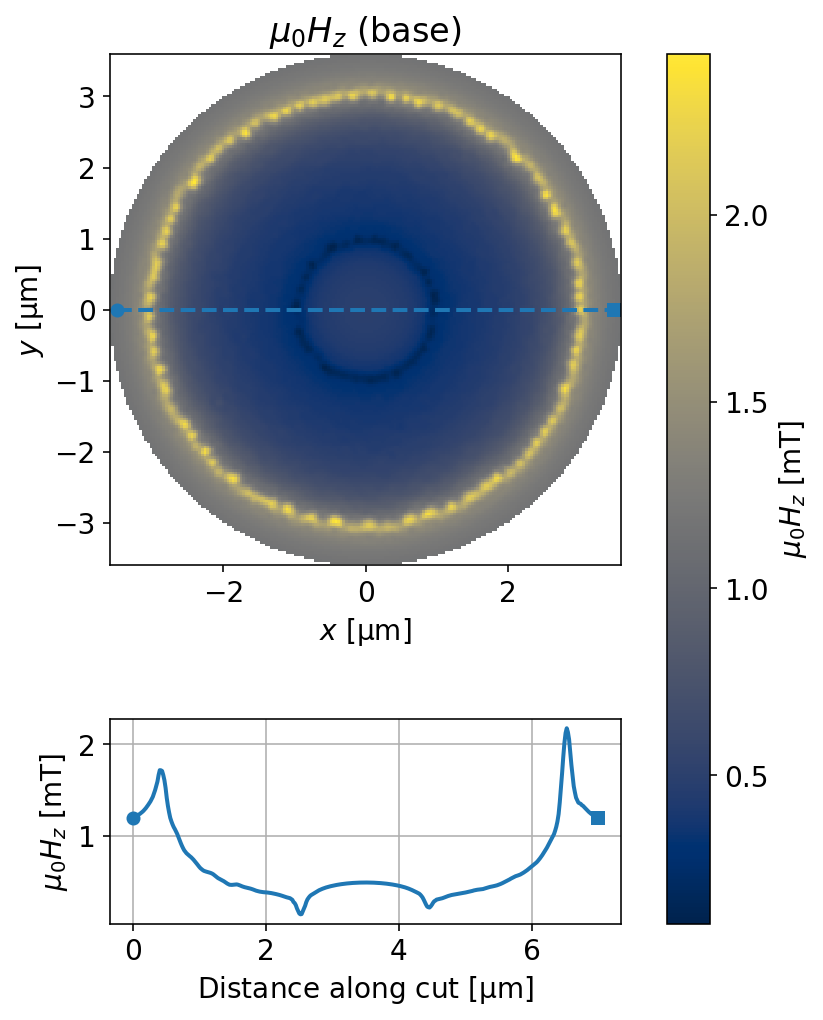

In [29]:
fig, axes = solution.plot_fields(
    cross_section_coords=cross_section_coords[:1], figsize=(6, 8)
)

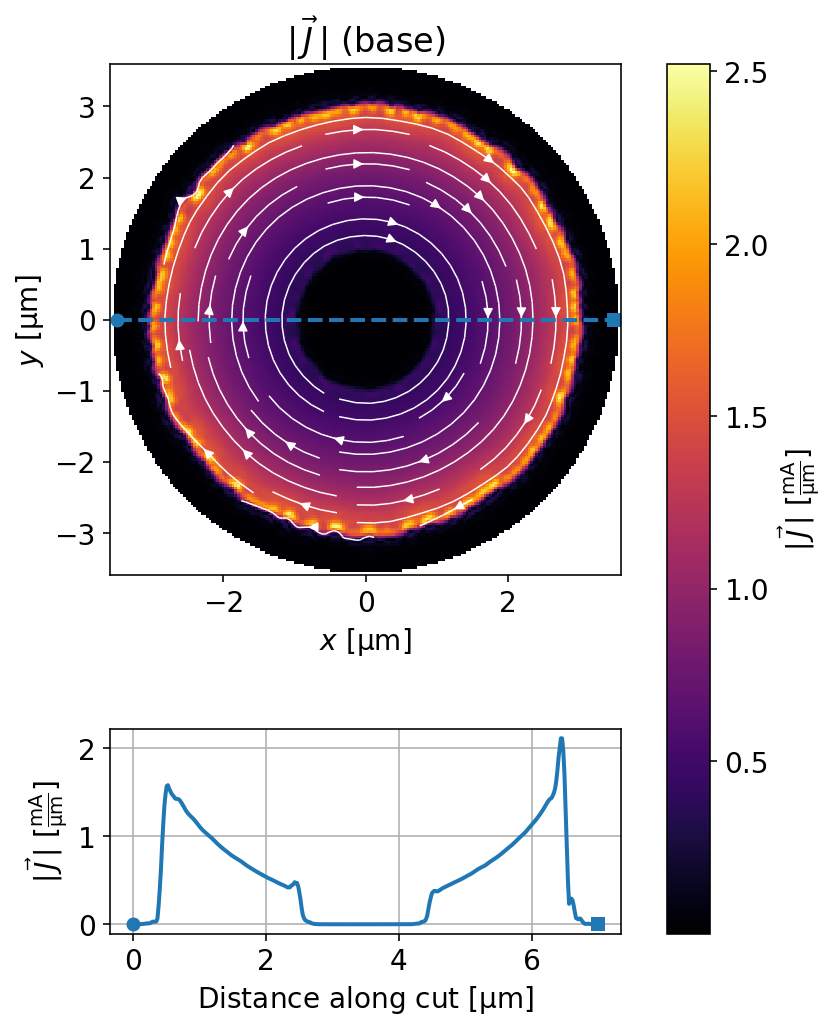

In [30]:
fig, axes = solution.plot_currents(
    cross_section_coords=cross_section_coords[:1], figsize=(6, 8)
)

Similarly, we can solve for a non-zero fluxoid state, in this case with no applied field. A non-zero fluxoid state can be realized by cooling a ring through its superconducting transition with an applied field.

In [31]:
# n = 1 fluxoid state, apply a field of 0 mT
solution, result = sc.find_fluxoid_solution(
    device,
    fluxoids=dict(hole=1),
    applied_field=sc.sources.ConstantField(0),
    field_units="mT",
    current_units="mA",
)
I_circ = solution.circulating_currents["hole"]
fluxoid = sum(solution.hole_fluxoid("hole")).to("Phi_0").magnitude
print("Root finding result:\n", result)
print(f"Total circulating current: {I_circ:.3f} mA.")
print(f"Total fluxoid: {fluxoid:.6f} Phi_0.")

INFO:superscreen.fluxoid:Finding fluxoid solution using root finding...
INFO:superscreen.solve:Calculating base response to applied field.
INFO:superscreen.solve:Calculating base response to applied field.
INFO:superscreen.solve:Calculating base response to applied field.


Root finding result:
       converged: True
           flag: 'converged'
 function_calls: 3
     iterations: 2
           root: 0.3566455543802983
Total circulating current: 0.357 mA.
Total fluxoid: 1.000000 Phi_0.


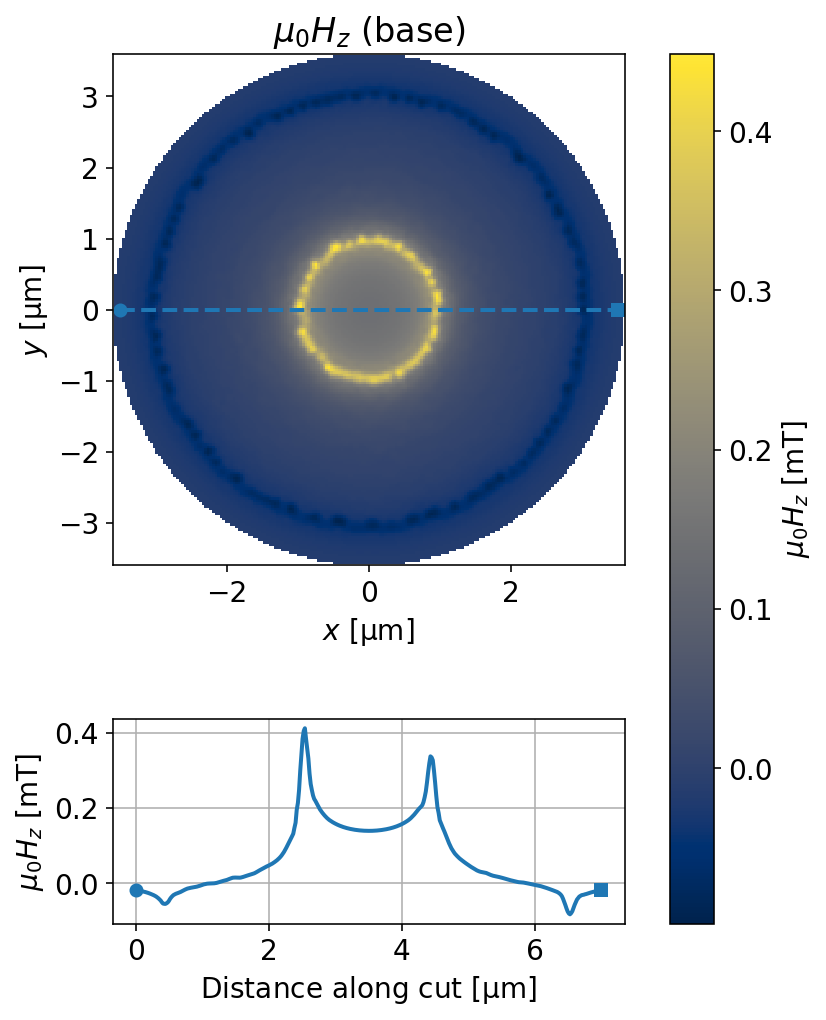

In [32]:
fig, axes = solution.plot_fields(
    cross_section_coords=cross_section_coords[:1], figsize=(6, 8)
)

## Film with multiple holes

Here we simulate a device with fewer symmetries than the ring, namely a rectangular film with two off-center rectangular holes.

In [33]:
length_units = "um"

layers = [
    sc.Layer("base", Lambda=0.1, z0=0),
]

films = [
    sc.Polygon("film", layer="base", points=box(8, 4)),
]

holes = [
    sc.Polygon("hole0", layer="base", points=box(5, 1, center=(0.5, -0.25))).resample(
        101
    ),
    sc.Polygon("hole1", layer="base", points=box(1, 2.5, center=(-3, 0.25))).resample(
        51
    ),
]

abstract_regions = [
    sc.Polygon("bounding_box", layer="base", points=box(9, 5)),
]

device = sc.Device(
    "rect",
    layers=layers,
    films=films,
    holes=holes,
    abstract_regions=abstract_regions,
    length_units=length_units,
)

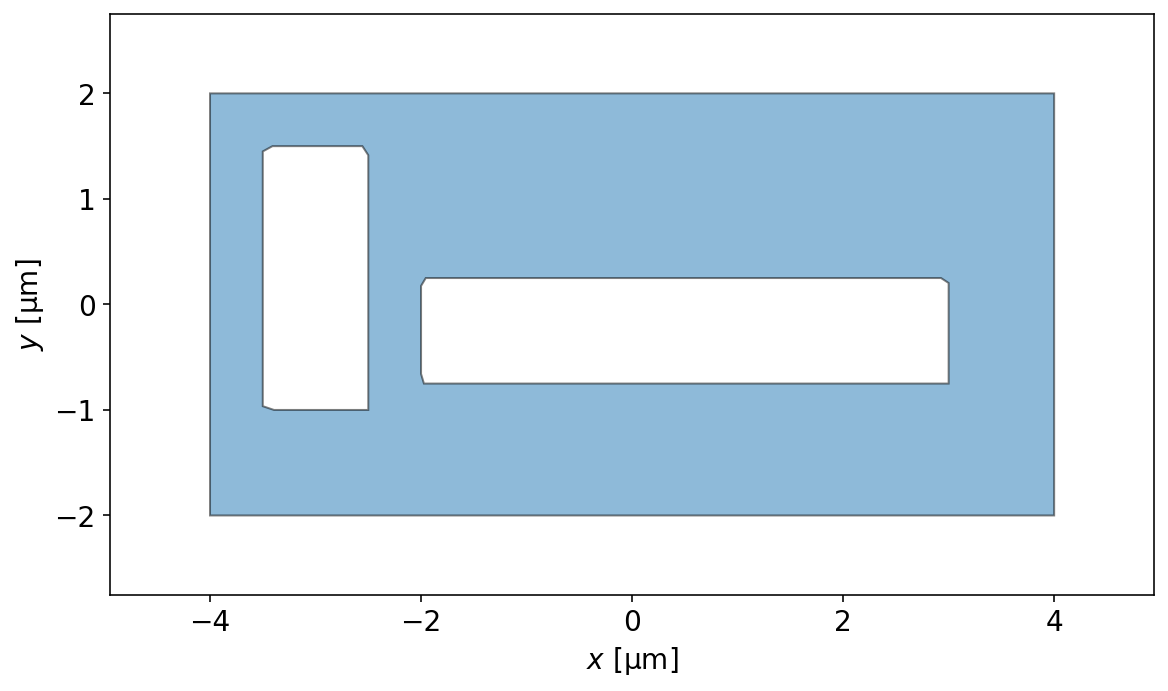

In [34]:
fig, ax = device.draw(exclude="bounding_box")

In [35]:
device.make_mesh(min_points=4_000, optimesh_steps=None)

INFO:superscreen.device.device:Generating mesh...
INFO:superscreen.device.device:Finished generating mesh with 4084 points and 7971 triangles.
INFO:superscreen.device.device:Calculating weight matrix.
INFO:superscreen.device.device:Calculating Laplace operator.
INFO:superscreen.device.device:Calculating kernel matrix.
INFO:superscreen.device.device:Calculating gradient matrix.


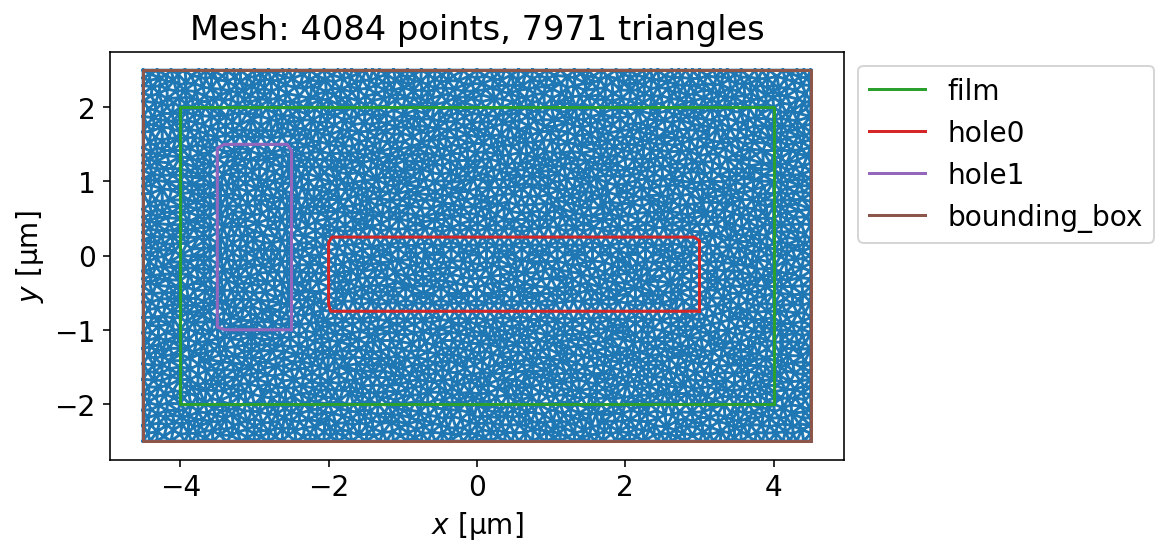

In [36]:
fig, ax = device.plot(mesh=True)
_ = ax.set_title(
    f"Mesh: {device.points.shape[0]} points, " f"{device.triangles.shape[0]} triangles"
)

### Full mutual inductance matrix

In [37]:
M = device.mutual_inductance_matrix(units="pH")
print(f"Mutual inductance matrix shape:", M.shape)
display(M)

INFO:superscreen.device.device:Evaluating 'rect' mutual inductance matrix column (1/2), source = 'hole0'.
INFO:superscreen.solve:Calculating base response to applied field.
INFO:superscreen.device.device:Evaluating fluxoids for solution 1/1.
INFO:superscreen.device.device:Evaluating 'rect' mutual inductance matrix column (2/2), source = 'hole1'.
INFO:superscreen.solve:Calculating base response to applied field.
INFO:superscreen.device.device:Evaluating fluxoids for solution 1/1.


Mutual inductance matrix shape: (2, 2)


Magnitude,[[6.411673813197214 -0.9926728089995721] [-0.9935563970136957 4.8661958014948405]]
Units,picohenry


As promised, the mutual inductance matrix is approximately symmetric:

In [38]:
asymmetry = float(np.abs((M[0, 1] - M[1, 0]) / min(M[0, 1], M[1, 0])))
print(f"Mutual inductance matrix fractional asymmetry: {100 * asymmetry:.3f}%")

Mutual inductance matrix fractional asymmetry: 0.089%


### Model both holes in the $n=0$ fluxoid state

In [39]:
# n = 0 fluxoid state, apply a field of 1 mT
solution, result = sc.find_fluxoid_solution(
    device,
    fluxoids=dict(hole0=0, hole1=0),
    applied_field=sc.sources.ConstantField(1),
    field_units="mT",
    current_units="mA",
)

INFO:superscreen.fluxoid:Finding fluxoid solution using least-squares minimization...
INFO:superscreen.fluxoid:Solving device with circulating_currents={'hole0': 0.0, 'hole1': 0.0}.
INFO:superscreen.solve:Calculating base response to applied field.
INFO:superscreen.fluxoid:Hole hole0: target = 0.000e+00 Phi_0, actual = 5.950e+00 Phi_0.
INFO:superscreen.fluxoid:Hole hole1: target = 0.000e+00 Phi_0, actual = 2.509e+00 Phi_0.
INFO:superscreen.fluxoid:Total cost = 4.169e+01 Phi_0 ** 2.
INFO:superscreen.fluxoid:Solving device with circulating_currents={'hole0': 1.4901161193847656e-08, 'hole1': 0.0}.
INFO:superscreen.solve:Calculating base response to applied field.
INFO:superscreen.fluxoid:Hole hole0: target = 0.000e+00 Phi_0, actual = 5.950e+00 Phi_0.
INFO:superscreen.fluxoid:Hole hole1: target = 0.000e+00 Phi_0, actual = 2.509e+00 Phi_0.
INFO:superscreen.fluxoid:Total cost = 4.169e+01 Phi_0 ** 2.
INFO:superscreen.fluxoid:Solving device with circulating_currents={'hole0': 0.0, 'hole1': 1.4

In [40]:
I_circ = solution.circulating_currents
fluxoids = [
    sum(solution.hole_fluxoid(hole)).to("Phi_0").magnitude
    for hole in ("hole0", "hole1")
]
print("Least-squares minimization result:\n", result)
print(f"Total circulating current: {I_circ} mA.")
print(f"Total fluxoid: {fluxoids} Phi_0.")

Least-squares minimization result:
       fun: 6.5019324628028534e-15
 hess_inv: array([[0.05776506, 0.02622886],
       [0.02622886, 0.09858884]])
      jac: array([-1.24923274e-07, -1.48199429e-07])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([-2.15188944, -1.50549475])
Total circulating current: {'hole0': -2.1518894387146013, 'hole1': -1.5054947385245894} mA.
Total fluxoid: [-6.03453076397642e-08, -2.553493155810216e-08] Phi_0.


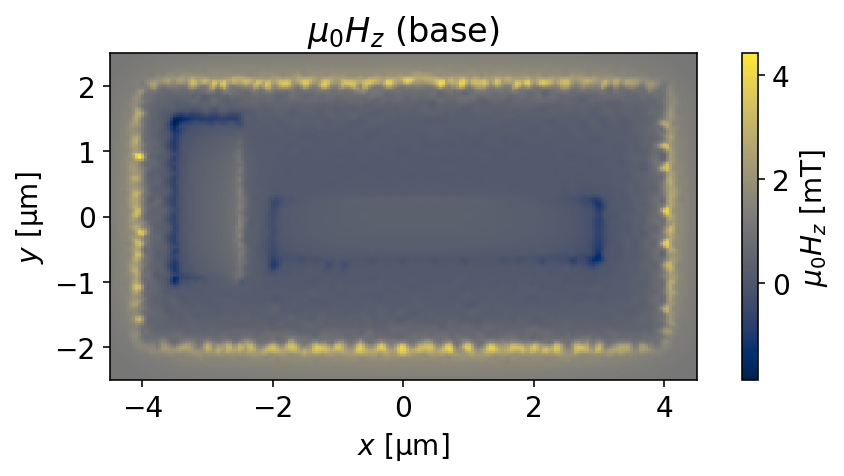

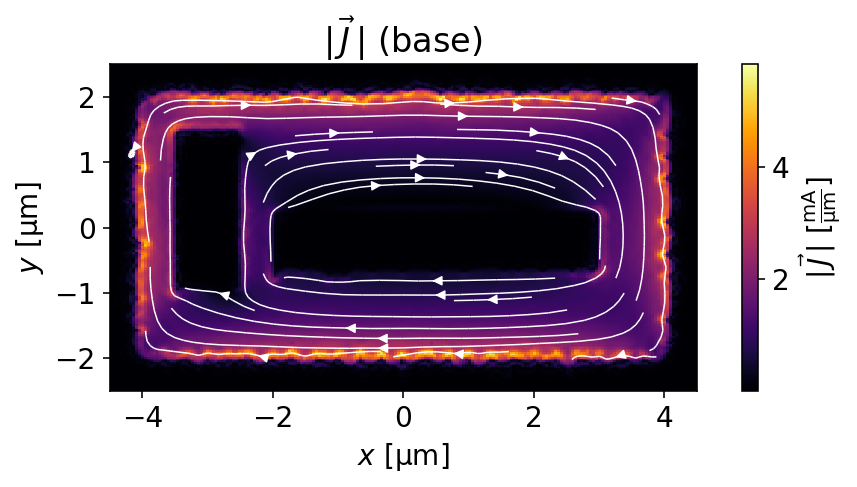

In [41]:
fig, axes = solution.plot_fields(figsize=(8, 3))
fig, axes = solution.plot_currents(figsize=(8, 3))

In [42]:
sc.version_table()

Software,Version
SuperScreen,0.4.0
Numpy,1.20.3
SciPy,1.6.3
matplotlib,3.4.3
ray,1.4.1
IPython,7.24.1
Python,"3.9.5 (default, May 18 2021, 12:31:01) [Clang 10.0.0 ]"
OS,posix [darwin]
Number of CPUs,"Physical: 2, Logical: 4"
BLAS Info,OPENBLAS
